In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import timeit
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.base import clone

a)


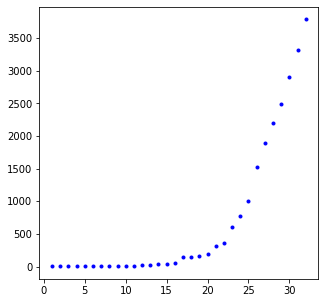

In [44]:
df = pd.read_csv('./covid19.csv', header=None)

x = df[0].to_numpy()
y = df[1].to_numpy()

x = x.reshape(len(x),1)
y = y.reshape(len(y),1)

fig = plt.figure(figsize=(5,5))
print('a)')
plt.plot(x, y, 'b.')

Holdout cross-validation (80/20%)
tamanho conjunto de treinamento: 25
tamanho conjunto de validação: 7

Minima da Média do Erro quadrático Médio: 20.457600047212583
Ordem do polinômio para a minima da Média do Erro quadrático Médio: 11
Tamanho de entrenamento para a minima da Média do Erro quadrático Médio: 1e-10

Tempo de execução: 0.5098 [s]


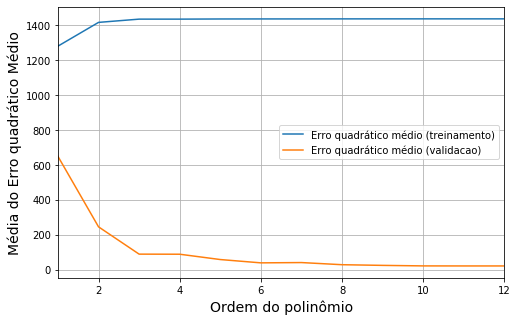

In [45]:
#b)
print("Holdout cross-validation (80/20%)")

# Get timestamp of holdout start.
starttime = timeit.default_timer()
include_bias = True

# Split the whole set into random training and validation set.
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=10)
print('tamanho conjunto de treinamento:', len(y_train))
print('tamanho conjunto de validação:', len(y_val))

lambdas = [10**(-10), 10**(-9), 10**(-8), 10**(-7), 10**(-6), 10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1), 10**(0)]
d_list = [i for i in range(1,13)]
errorTrain = np.zeros((len(lambdas),len(d_list)))
error = np.zeros((len(lambdas),len(d_list)))
minimum_val_error = float("inf")

for index_d, d in enumerate(d_list):
    for index_l, l in enumerate(lambdas):
        # Instantiate a polynomial with the given degree.
        poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
        # Instantiate a scaler that will standardize the features.
        std_scaler = StandardScaler()
        # Instantiate a Ridge regressor.
        reg = Ridge(alpha=l, solver="cholesky")
        # Create a pipeline of actions.
        polynomial_regression = Pipeline([
            ("poly_features", poly_features),
            ("std_scaler", std_scaler),
            ("reg", reg),
        ])

        polynomial_regression.fit(x_train, y_train)
    
        y_train_predict = polynomial_regression.predict(x_train)
        y_val_predict = polynomial_regression.predict(x_val)
        
        errorTrain[index_l,index_d] = np.sqrt(mean_squared_error(y_train_predict, x_train))
        error[index_l,index_d] = np.sqrt(mean_squared_error(y_val, y_val_predict))
        
        if np.sqrt(mean_squared_error(y_val, y_val_predict)) < minimum_val_error:
            best_lambda = l
            best_index = index_l
            minimum_val_error = np.sqrt(mean_squared_error(y_val, y_val_predict))
            #best_model = clone(model, safe=True)
            best_d = d

print('\nMinima da Média do Erro quadrático Médio: ' + str(minimum_val_error))
print('Ordem do polinômio para a minima da Média do Erro quadrático Médio: ' + str(best_d))
print('Tamanho de entrenamento para a minima da Média do Erro quadrático Médio: ' + str(best_lambda))

plt.figure(figsize=(8, 5))
plt.plot(d_list, errorTrain[best_index, :],  label='Erro quadrático médio (treinamento)')
plt.plot(d_list, error[best_index, :],  label='Erro quadrático médio (validacao)')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do Erro quadrático Médio', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()
plt.show
    
print("\nTempo de execução: %1.4f [s]" % (timeit.default_timer() - starttime))

k-fold cross-validation (k=10)

Minima da Média do Erro quadrático Médio: 39.9152910933592
Ordem do polinômio para a minima da Média do Erro quadrático Médio: 10
Tamanho de entrenamento para a minima da Média do Erro quadrático Médio: 1e-08

Tempo de execução: 4.3223 [s]


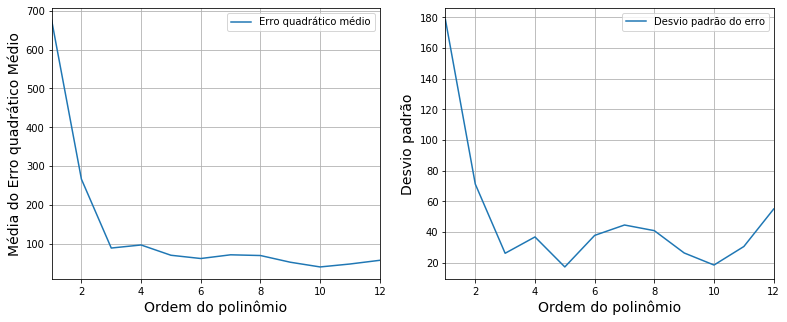

In [46]:
print('k-fold cross-validation (k=10)')

minimum_train_erro = float("inf")

# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Instantiate the k-Fold object.
kfold = KFold(n_splits=10, shuffle=True, random_state=100)

lambdas = [10**(-10), 10**(-9), 10**(-8), 10**(-7), 10**(-6), 10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1), 10**(0)]
d_list = [i for i in range(1,13)]

error = np.zeros((len(lambdas),len(d_list)))
std_vec = np.zeros((len(lambdas),len(d_list)))

minimum_val_error = float("inf")

best_lambda = 0
best_index = 0
best_d = 0

for index_d, d in enumerate(d_list):
    for index_l, l in enumerate(lambdas):
        # Instantiate a polynomial with the given degree.
        poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
        # Instantiate a scaler that will standardize the features.
        std_scaler = StandardScaler()
        # Instantiate a Ridge regressor.
        reg = Ridge(alpha=l, solver="cholesky")
        # Create a pipeline of actions.
        polynomial_regression = Pipeline([
            ("poly_features", poly_features),
            ("std_scaler", std_scaler),
            ("reg", reg),
        ])

        lin_scores = cross_val_score(polynomial_regression, x, y, scoring='neg_mean_squared_error', cv=kfold)
        
        scores = np.sqrt(-lin_scores)
        
        error[index_l,index_d] = scores.mean()
        std_vec[index_l,index_d] = scores.std()
        
        if scores.mean() < minimum_train_erro:
            best_lambda = l
            best_index = index_l
            minimum_train_erro = scores.mean()
            best_d = d

print('\nMinima da Média do Erro quadrático Médio: ' + str(minimum_train_erro))
print('Ordem do polinômio para a minima da Média do Erro quadrático Médio: ' + str(best_d))
print('Tamanho de entrenamento para a minima da Média do Erro quadrático Médio: ' + str(best_lambda))


# Plot results.
plt.figure(figsize=(20, 5))
ax = plt.subplot(1, 3, 1)
plt.plot(d_list, error[best_index, :],  label='Erro quadrático médio')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do Erro quadrático Médio', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

ax = plt.subplot(1, 3, 2)
plt.plot(d_list, std_vec[best_index, :],  label='Desvio padrão do erro')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Desvio padrão', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

print("\nTempo de execução: %1.4f [s]" % (timeit.default_timer() - starttime))

kLeave-one-out cross-validation

Minima da Média do Erro quadrático Médio: 35.90247841085399
Ordem do polinômio para a minima da Média do Erro quadrático Médio: 10
Tamanho de entrenamento para a minima da Média do Erro quadrático Médio: 1e-08

Tempo de execução: 13.4730 [s]


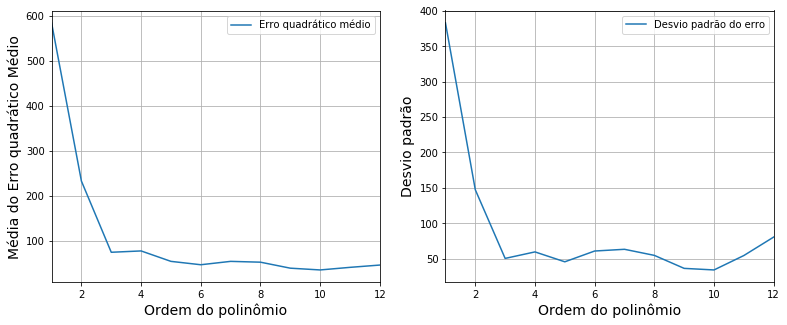

In [47]:
print('kLeave-one-out cross-validation')

minimum_train_erro = float("inf")

# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Instantiate the LOOCV object.
loocv = LeaveOneOut()

lambdas = [10**(-10), 10**(-9), 10**(-8), 10**(-7), 10**(-6), 10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1), 10**(0)]
d_list = [i for i in range(1,13)]

error = np.zeros((len(lambdas),len(d_list)))
std_vec = np.zeros((len(lambdas),len(d_list)))

minimum_val_error = float("inf")

best_lambda = 0
best_index = 0
best_d = 0

for index_d, d in enumerate(d_list):
    for index_l, l in enumerate(lambdas):
        # Instantiate a polynomial with the given degree.
        poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
        # Instantiate a scaler that will standardize the features.
        std_scaler = StandardScaler()
        # Instantiate a Ridge regressor.
        reg = Ridge(alpha=l, solver="cholesky")
        # Create a pipeline of actions.
        polynomial_regression = Pipeline([
            ("poly_features", poly_features),
            ("std_scaler", std_scaler),
            ("reg", reg),
        ])

        lin_scores = cross_val_score(polynomial_regression, x, y, scoring='neg_mean_squared_error', cv=loocv)
        
        scores = np.sqrt(-lin_scores)
        
        error[index_l,index_d] = scores.mean()
        std_vec[index_l,index_d] = scores.std()
        
        if scores.mean() < minimum_train_erro:
            best_lambda = l
            best_index = index_l
            minimum_train_erro = scores.mean()
            best_d = d

print('\nMinima da Média do Erro quadrático Médio: ' + str(minimum_train_erro))
print('Ordem do polinômio para a minima da Média do Erro quadrático Médio: ' + str(best_d))
print('Tamanho de entrenamento para a minima da Média do Erro quadrático Médio: ' + str(best_lambda))


# Plot results.
plt.figure(figsize=(20, 5))
ax = plt.subplot(1, 3, 1)
plt.plot(d_list, error[best_index, :],  label='Erro quadrático médio')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do Erro quadrático Médio', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

ax = plt.subplot(1, 3, 2)
plt.plot(d_list, std_vec[best_index, :],  label='Desvio padrão do erro')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Desvio padrão', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

print("\nTempo de execução: %1.4f [s]" % (timeit.default_timer() - starttime))

In [56]:
#c)
# Instantiate a polynomial with the given degree.
poly_features = PolynomialFeatures(degree=11, include_bias=include_bias)
# Instantiate a scaler that will standardize the features.
std_scaler = StandardScaler()
# Instantiate a Ridge regressor.
reg = Ridge(alpha=10**(-10), solver="cholesky")
# Create a pipeline of actions.
polynomial_regression = Pipeline([
    ("poly_features", poly_features),
    ("std_scaler", std_scaler),
    ("reg", reg),
])

polynomial_regression.fit(x, y)

Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=11, include_bias=True,
                                    interaction_only=False, order='C')),
                ('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 Ridge(alpha=1e-10, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='cholesky', tol=0.001))],
         verbose=False)

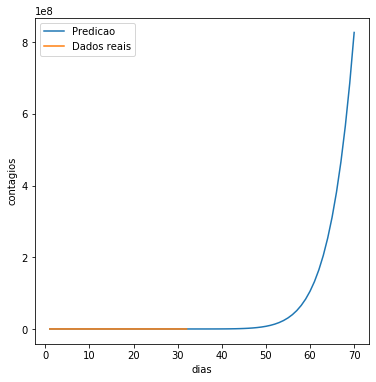

dia: 1 -> 4 contagiados
dia: 2 -> -2 contagiados
dia: 3 -> -3 contagiados
dia: 4 -> 0 contagiados
dia: 5 -> 5 contagiados
dia: 6 -> 8 contagiados
dia: 7 -> 7 contagiados
dia: 8 -> 4 contagiados
dia: 9 -> 1 contagiados
dia: 10 -> 0 contagiados
dia: 11 -> 3 contagiados
dia: 12 -> 12 contagiados
dia: 13 -> 26 contagiados
dia: 14 -> 44 contagiados
dia: 15 -> 64 contagiados
dia: 16 -> 84 contagiados
dia: 17 -> 105 contagiados
dia: 18 -> 129 contagiados
dia: 19 -> 161 contagiados
dia: 20 -> 210 contagiados
dia: 21 -> 288 contagiados
dia: 22 -> 406 contagiados
dia: 23 -> 576 contagiados
dia: 24 -> 806 contagiados
dia: 25 -> 1098 contagiados
dia: 26 -> 1442 contagiados
dia: 27 -> 1819 contagiados
dia: 28 -> 2202 contagiados
dia: 29 -> 2567 contagiados
dia: 30 -> 2909 contagiados
dia: 31 -> 3271 contagiados
dia: 32 -> 3802 contagiados
dia: 33 -> 4820 contagiados
dia: 34 -> 6928 contagiados
dia: 35 -> 11158 contagiados
dia: 36 -> 19172 contagiados
dia: 37 -> 33533 contagiados
dia: 38 -> 58047 co

In [57]:
#d)
y_predictx = polynomial_regression.predict(x)
fig = plt.figure(figsize=(6,6))

x_predict = np.linspace(1, 70, 70)
x_predict = x_predict.reshape(len(x_predict),1)
y_predict = polynomial_regression.predict(x_predict)

plt.plot(x_predict, y_predict, label='Predicao')
plt.plot(x, y, label='Dados reais')
plt.xlabel('dias')
plt.ylabel('contagios')
plt.legend()
plt.show()
for i, value in enumerate(y_predict):
    print('dia: ' + str(i+1) + ' -> ' + str(int(value)) + ' contagiados')

In [58]:
for i, value in enumerate(y_predict):
    if value >= 40600:
        print('e) O número de leitos total seria atingido após ' + str(i+1) + ' dias do primeiro caso')
        break

e) O número de leitos total seria atingido após 38 dias do primeiro caso
